In [7]:
import configs_py3 as configs
import utilities as utils
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import date


In [82]:
def get_thresholded_output(original_model_outputs, softmax_outputs, threshold=0.5):
    thresholded_model_outputs = []
    for idx in range(len(softmax_outputs)):
        
        if softmax_outputs[idx] < threshold:
            thresholded_model_outputs.append("ABSTAIN")
        else:
            thresholded_model_outputs.append(original_model_outputs[idx])
    return thresholded_model_outputs

In [105]:
def get_eval_dicts(val_df):
    
    for threshold in np.arange(0.1, 1.0, 0.1):
        threshold = round(threshold,1)
        
        model_outputs = val_df[f'thresholded_model_outputs_{threshold}']
        
        desired_output_original_question = list(val_df['multiple_choice_answer'][:len(val_df)//2])
        desired_output_random_question = ["ABSTAIN" for val in range(len(val_df)//2, len(val_df))]
        
        desired_output = desired_output_original_question + desired_output_random_question
        
        
        
        
    return desired_output
desired_output = get_eval_dicts(val_df)    
print(len(desired_output))

500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
1000


In [83]:
def get_eval_dicts(val_df):
    
    accuracy_dict = {}
    abstain_acc_dict = {}
    abstain_y_true_dict = {}
    abstain_y_pred_dict = {}
    for threshold in np.arange(0.1, 1.0, 0.1):
        threshold = round(threshold,1)
        
        
        
        
        for index, row in val_df.iterrows():
            
            model_output = row[f'thresholded_model_outputs_{threshold}']            
            desired_output = row['multiple_choice_answer'] if index < len(val_df)//2 else "ABSTAIN"
            
            
            abstain_y_true = 0  if index < len(val_df)//2 else 1
            abstain_y_pred = 1 if model_output == "ABSTAIN" else 0     
            
            
            if threshold not in abstain_y_true_dict:
                abstain_y_true_dict[threshold] = []
                abstain_y_pred_dict[threshold] = []
            abstain_y_true_dict[threshold].append(abstain_y_true)
            abstain_y_pred_dict[threshold].append(abstain_y_pred)
                   
            if y_true in y_pred and y_true == "ABSTAIN" and y_pred != "ABSTAIN":
                print(index, row.original_question, row.multiple_choice_answer, row.random_question, y_true, y_pred)
                accuracy_dict[threshold] = accuracy_dict.get(threshold, 0) + 1
            
            if y_true == "ABSTAIN" and y_pred == "ABSTAIN":
                abstain_acc_dict[threshold] = abstain_acc_dict.get(threshold, 0) + 1
            elif "ABSTAIN" not in y_true and "ABSTAIN" not in y_pred:
                abstain_acc_dict[threshold] = abstain_acc_dict.get(threshold, 0) + 1
        print("accuracy_dict[threshold]",accuracy_dict[threshold])
        accuracy_dict[threshold] = accuracy_dict[threshold] / (len(val_df)//2)
        print("accuracy_dict[threshold]", accuracy_dict[threshold], "len(val_df)//2", len(val_df)//2)
        abstain_acc_dict[threshold] = abstain_acc_dict[threshold] / len(val_df)
    return accuracy_dict, abstain_acc_dict, abstain_y_true_dict, abstain_y_pred_dict


/n/fs/nlp-runzhey/diplomacy/iw-spring-23/utils/utilities.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/fs/nlp-runzhey/diplomacy/iw-spring-23/utils/utilities.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_model_outputs.append(model.config.id2label[idx])


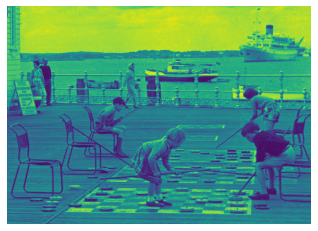

Unsupported number of image dimensions: 2 ==> Skipping this image


In [84]:
# get outputs with softmax scores
# first half of val set with original questions
# second half with random questions

val_df = utils.load_dataset(split='val')

val_df_original, outputs_original, softmax_original = utils.get_raw_vqa_output(
    df=val_df[:len(val_df)//2], 
    random_question=False)

val_df_random, outputs_random, softmax_random = utils.get_raw_vqa_output(
    df=val_df[len(val_df)//2:],
    random_question=True)

In [88]:
#combine both dfs
val_df = pd.concat([val_df_original, val_df_random], ignore_index=True)


for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    thresholded_model_outputs = get_thresholded_output(original_model_outputs, softmax_outputs, threshold=threshold)
    val_df[f'thresholded_model_outputs_{threshold}'] = thresholded_model_outputs
   
    
    
val_df.to_csv(configs.output_path, index=False)

In [86]:
# create results file in required format
val_df = pd.read_csv(configs.output_path, index_col=False)

results = []
for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    for index, row in val_df.iterrows():
        question_id = row['question_id']
        answer = row[f'thresholded_model_outputs_{threshold}']
        result = {"question_id": question_id, "answer": answer}
        results.append(result)

    # store results in json file

    resFile = '%s/Results/%s%s_%s_%s_results_%s.json' %(configs.dataDir, configs.versionType, configs.taskType, 
                                                        configs.dataType, configs.dataSubType, threshold)
    json.dump(results, open(resFile, 'w'))


In [87]:
accuracy_dict, abstain_acc_dict, abstain_y_true_dict, abstain_y_pred_dict = get_eval_dicts(val_df)

KeyError: 0.1

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix


for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    print(f"Threshold: {threshold}")
    print(classification_report(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold]))
    print(confusion_matrix(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold]))
    

Threshold: 0.1
              precision    recall  f1-score   support

           0       0.50      0.98      0.67       500
           1       0.62      0.03      0.05       500

    accuracy                           0.51      1000
   macro avg       0.56      0.51      0.36      1000
weighted avg       0.56      0.51      0.36      1000

[[492   8]
 [487  13]]
Threshold: 0.2
              precision    recall  f1-score   support

           0       0.50      0.92      0.65       500
           1       0.51      0.08      0.14       500

    accuracy                           0.50      1000
   macro avg       0.51      0.50      0.39      1000
weighted avg       0.51      0.50      0.39      1000

[[462  38]
 [460  40]]
Threshold: 0.3
              precision    recall  f1-score   support

           0       0.50      0.86      0.63       500
           1       0.50      0.14      0.22       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50    

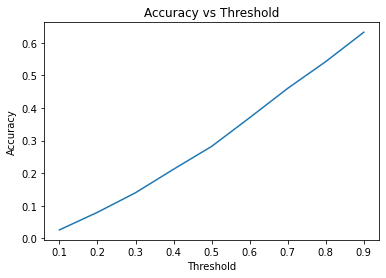

In [75]:
plt.plot(list(accuracy_dict.keys()), list(accuracy_dict.values()), label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.show()

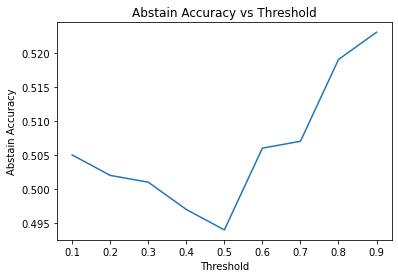

In [76]:
plt.plot(list(abstain_acc_dict.keys()), list(abstain_acc_dict.values()), label="Abstain Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Abstain Accuracy")
plt.title("Abstain Accuracy vs Threshold")
plt.show()

In [15]:
threshold = 0.5

raw_output = pd.read_csv(configs.output_path, index_col=False)[f"thresholded_model_outputs_{threshold}"]

related_question_output = raw_output[:len(raw_output)//2]
unrelated_question_output = raw_output[len(raw_output)//2:]

In [16]:
distribution_of_answers_df = pd.DataFrame({"related_question_output": related_question_output.value_counts(), 
                                        "unrelated_question_output": unrelated_question_output.value_counts()})
distribution_of_answers_df.to_csv("%s/output/%s-distribution-of-answers.csv" % (configs.ROOT, date.today()))

In [58]:
# show top 25 answers
distribution_of_answers_df.sort_values(by="unrelated_question_output", ascending=False).head(25)

,related_question_output,unrelated_question_output
ABSTAIN,147.0,141.0
white,16.0,27.0
brown,8.0,12.0
black,7.0,11.0
red,15.0,11.0
green,9.0,10.0
blue,13.0,10.0
yellow,11.0,7.0
frisbee,5.0,6.0
right,1.0,5.0


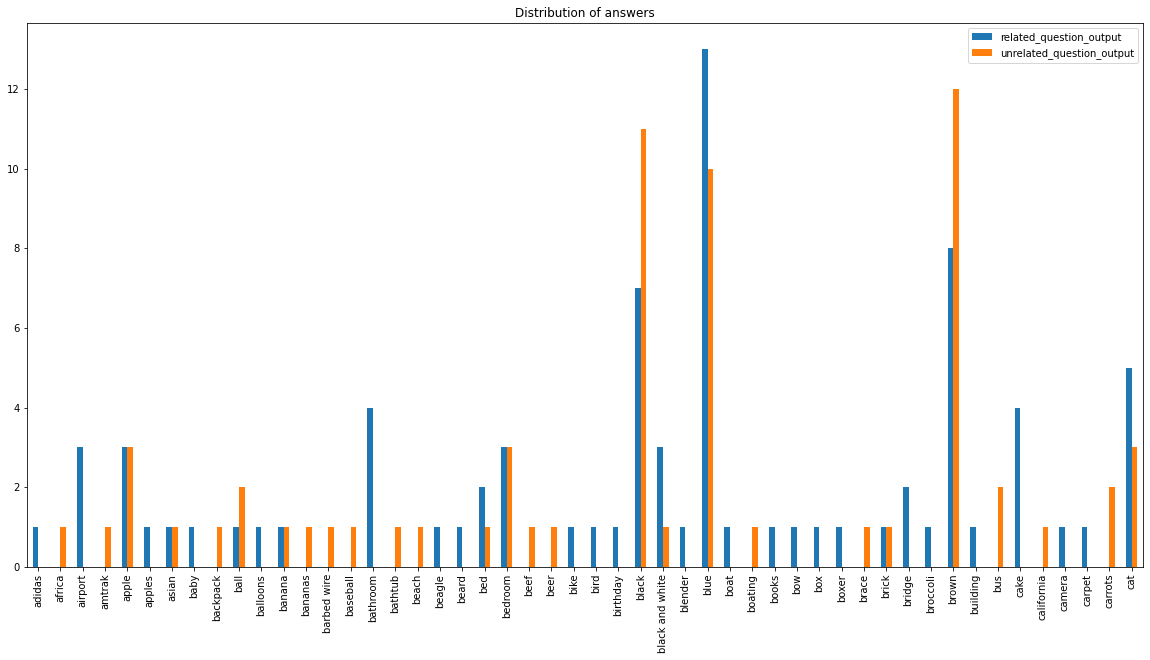

In [59]:
# plot histogram after removing ABSTAIN
distribution_of_answers_df.drop(["ABSTAIN"]).head(50).plot(kind='bar', figsize=(20,10), title="Distribution of answers")
plt.show()